Group Machine Learning
- 2702382221 Muhammad Aryo Baskoro
- 2702280844 Winsen Olando
- 2702264563 Leonard Vanderson Gani

In [33]:
%pip install pandas numpy matplotlib seaborn
%pip install scikit-learn xgboost imbalanced-learn
%pip install nltk contractions wordcloud

import pickle
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from scipy.sparse import hstack

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to C:\Users\KR24-
[nltk_data]     1.SOFTWARELABCNTR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\KR24-
[nltk_data]     1.SOFTWARELABCNTR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KR24-
[nltk_data]     1.SOFTWARELABCNTR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

EDA (Exploratory Data Analysis) -> Before Preprocessing

---

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [36]:
data.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [37]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [38]:
data.isna().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

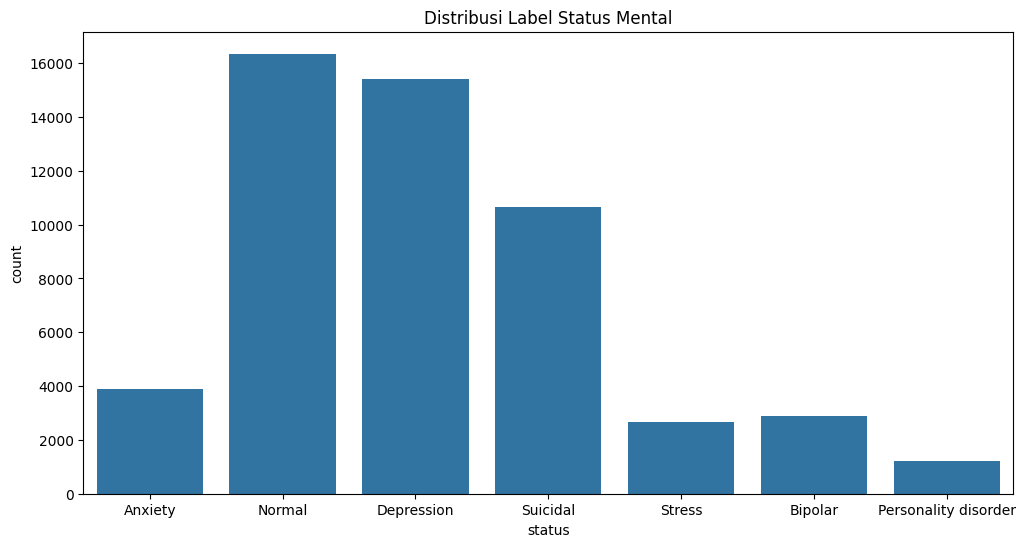

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(x='status', data=data)
plt.title("Distribusi Label Status Mental")
plt.show()

In [40]:
print(data['status'].value_counts())

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


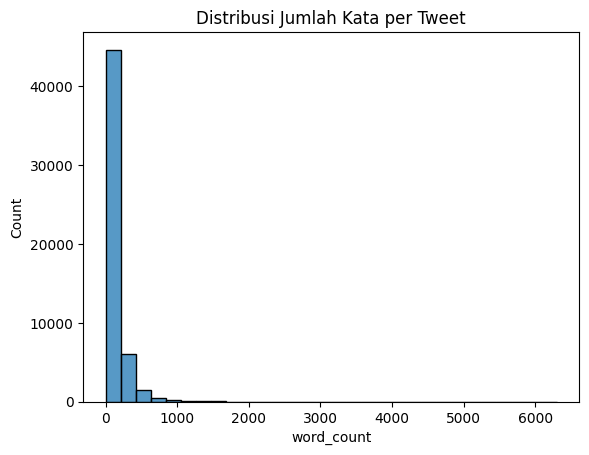

In [41]:
data['statement'] = data['statement'].astype(str).fillna("")

data['tweet_length'] = data['statement'].apply(lambda x: len(x))
data['word_count'] = data['statement'].apply(lambda x: len(x.split()))

sns.histplot(data['word_count'], bins=30)
plt.title("Distribusi Jumlah Kata per Tweet")
plt.show()

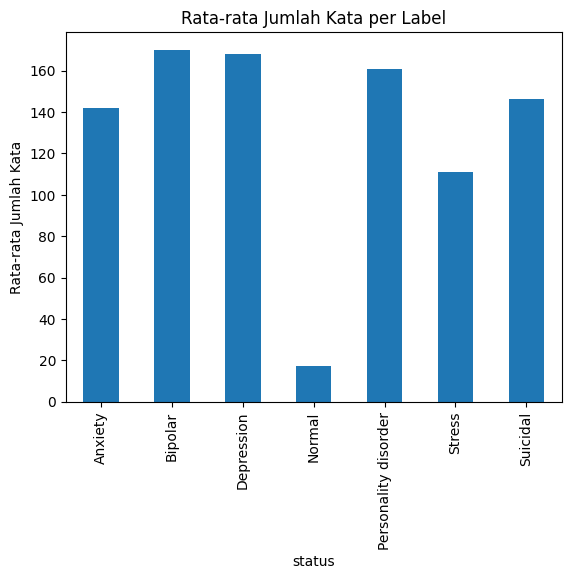

In [42]:
data.groupby('status')['word_count'].mean().plot(kind='bar')
plt.title("Rata-rata Jumlah Kata per Label")
plt.ylabel("Rata-rata Jumlah Kata")
plt.show()

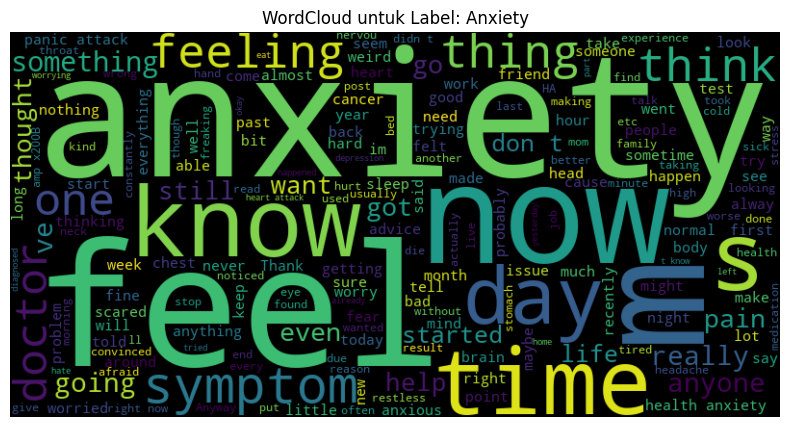

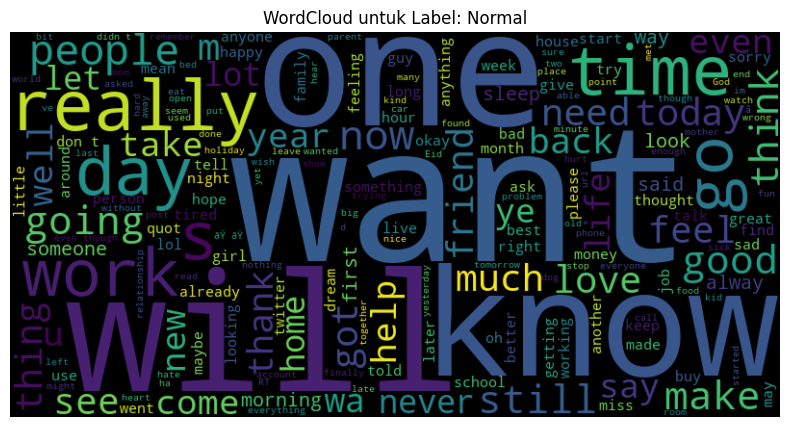

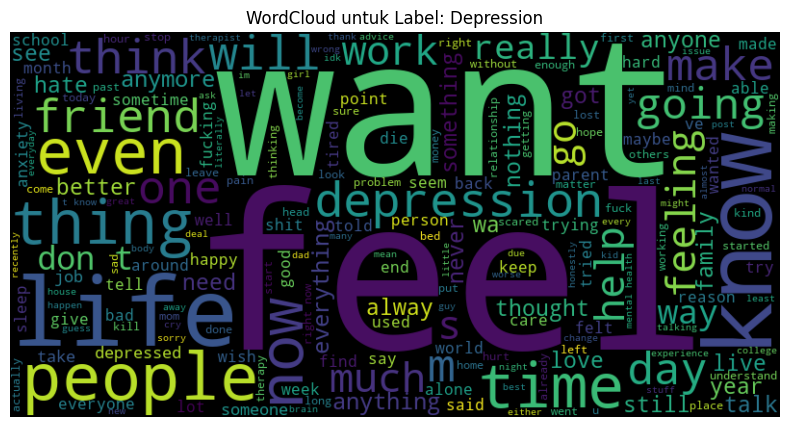

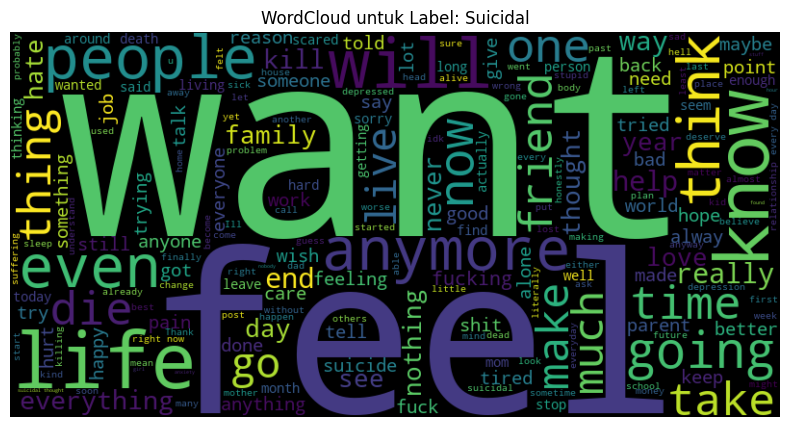

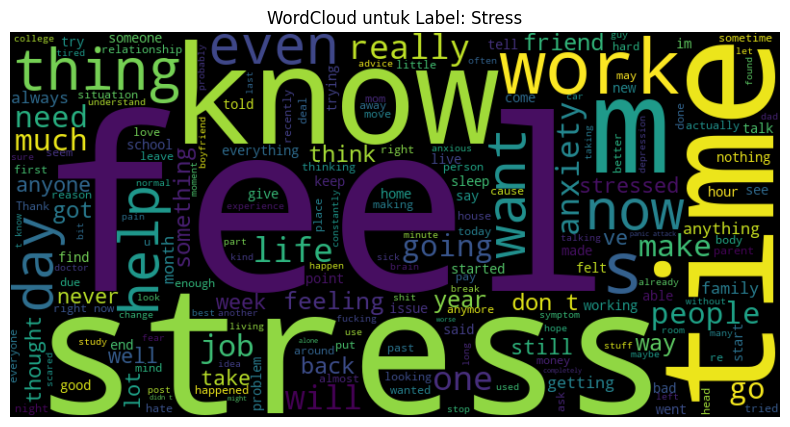

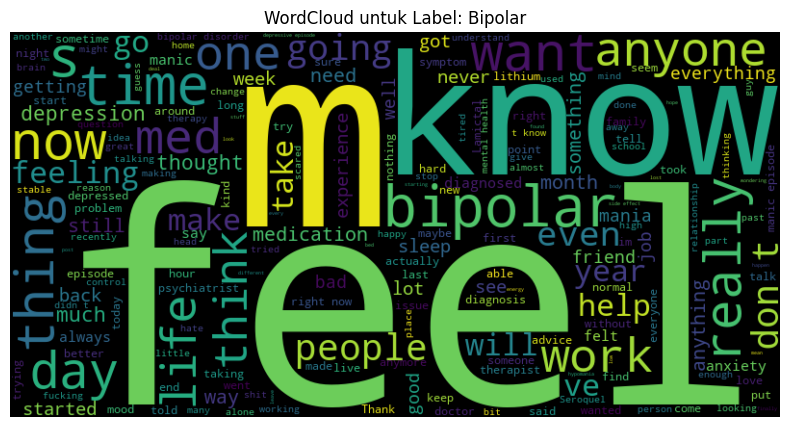

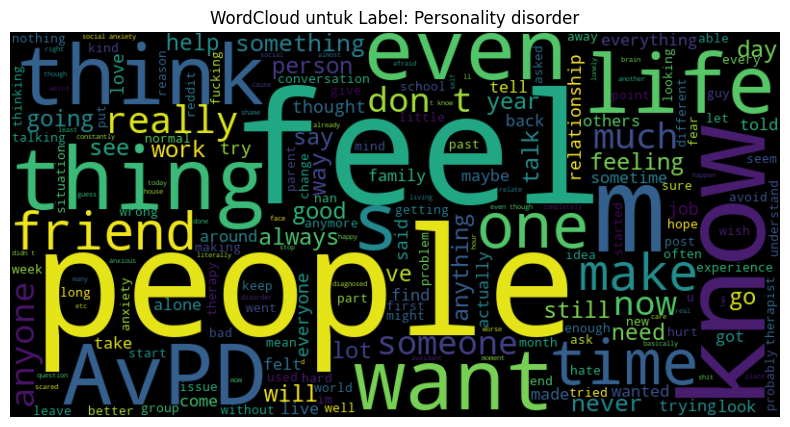

In [43]:
for label in data['status'].unique():
    text = ' '.join(data[data['status'] == label]['statement'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud untuk Label: {label}")
    plt.show()

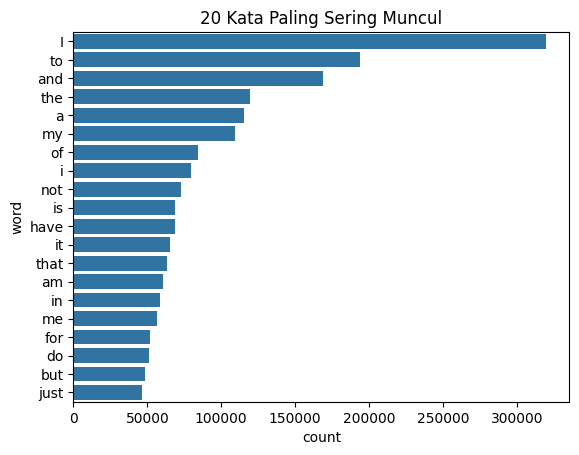

In [44]:
all_words = ' '.join(data['statement']).split()
most_common = Counter(all_words).most_common(20)

df_freq = pd.DataFrame(most_common, columns=['word', 'count'])
sns.barplot(data=df_freq, x='count', y='word')
plt.title("20 Kata Paling Sering Muncul")
plt.show()

Preprocessing

In [45]:
data['num_of_characters'] = data['statement'].fillna("").apply(len)

def count_sentences(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return len(sentences)

data['num_of_sentences'] = data['statement'].fillna("").apply(count_sentences)
data[data['num_of_characters'] > 10000]

,Unnamed: 0,statement,status,tweet_length,word_count,num_of_characters,num_of_sentences
7851,7851,So introduction I guess.. my name is Michael a...,Depression,10679,2153,10679,150
9416,9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,8,25302,1
9504,9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,2139,11163,159
10834,10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,5248,27390,244
11537,11537,"The title is not meant to discourage others, b...",Depression,12304,2391,12304,166
11581,11581,I no longer know what else to do but write thi...,Depression,13530,2612,13530,141
11636,11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,2415,12819,106
11831,11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,2187,11122,162
13293,13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,6300,32759,1260
18215,18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,2066,10219,193


In [46]:
def expand_contractions(text):
    return contractions.fix(text)

def remove_urls(text):
    return re.sub(r"http\S+|www.\S+", "", text)

def remove_mentions(text):
    return re.sub(r"@\w+", "", text)

def remove_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_special_chars(text):
    allowed = string.ascii_letters + "áéíóúãõàâêôç!?.,'\" "
    return ''.join(c for c in text if c in allowed)

def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower().strip()
    text = expand_contractions(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emojis(text)
    text = remove_special_chars(text)
    text = re.sub(r'\s+', ' ', text)

    return text

data['statement'] = data['statement'].apply(clean_text)

In [47]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

if "unnamed" in data.columns:
    data = data.drop(columns=["unnamed"])
if "Unnamed: 0" in data.columns:
    data = data.drop(columns=["Unnamed: 0"])

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

data['Processed_Tweet'] = data['statement'].astype(str).fillna("").apply(preprocess)
data = data[data['Processed_Tweet'].str.strip() != '']

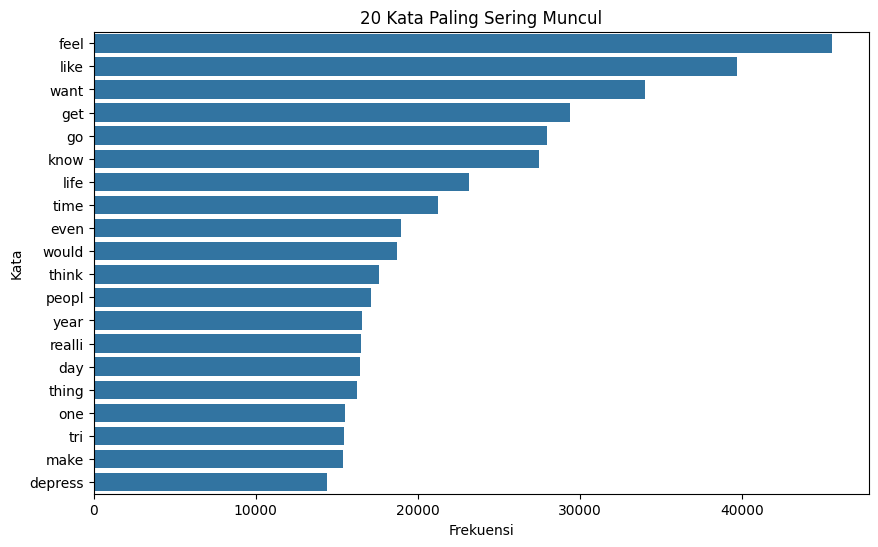

In [48]:
all_words = ' '.join(data['Processed_Tweet']).split()
most_common = Counter(all_words).most_common(20)

df_freq = pd.DataFrame(most_common, columns=['word', 'count'])
plt.figure(figsize=(10,6))
sns.barplot(data=df_freq, x='count', y='word')
plt.title("20 Kata Paling Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

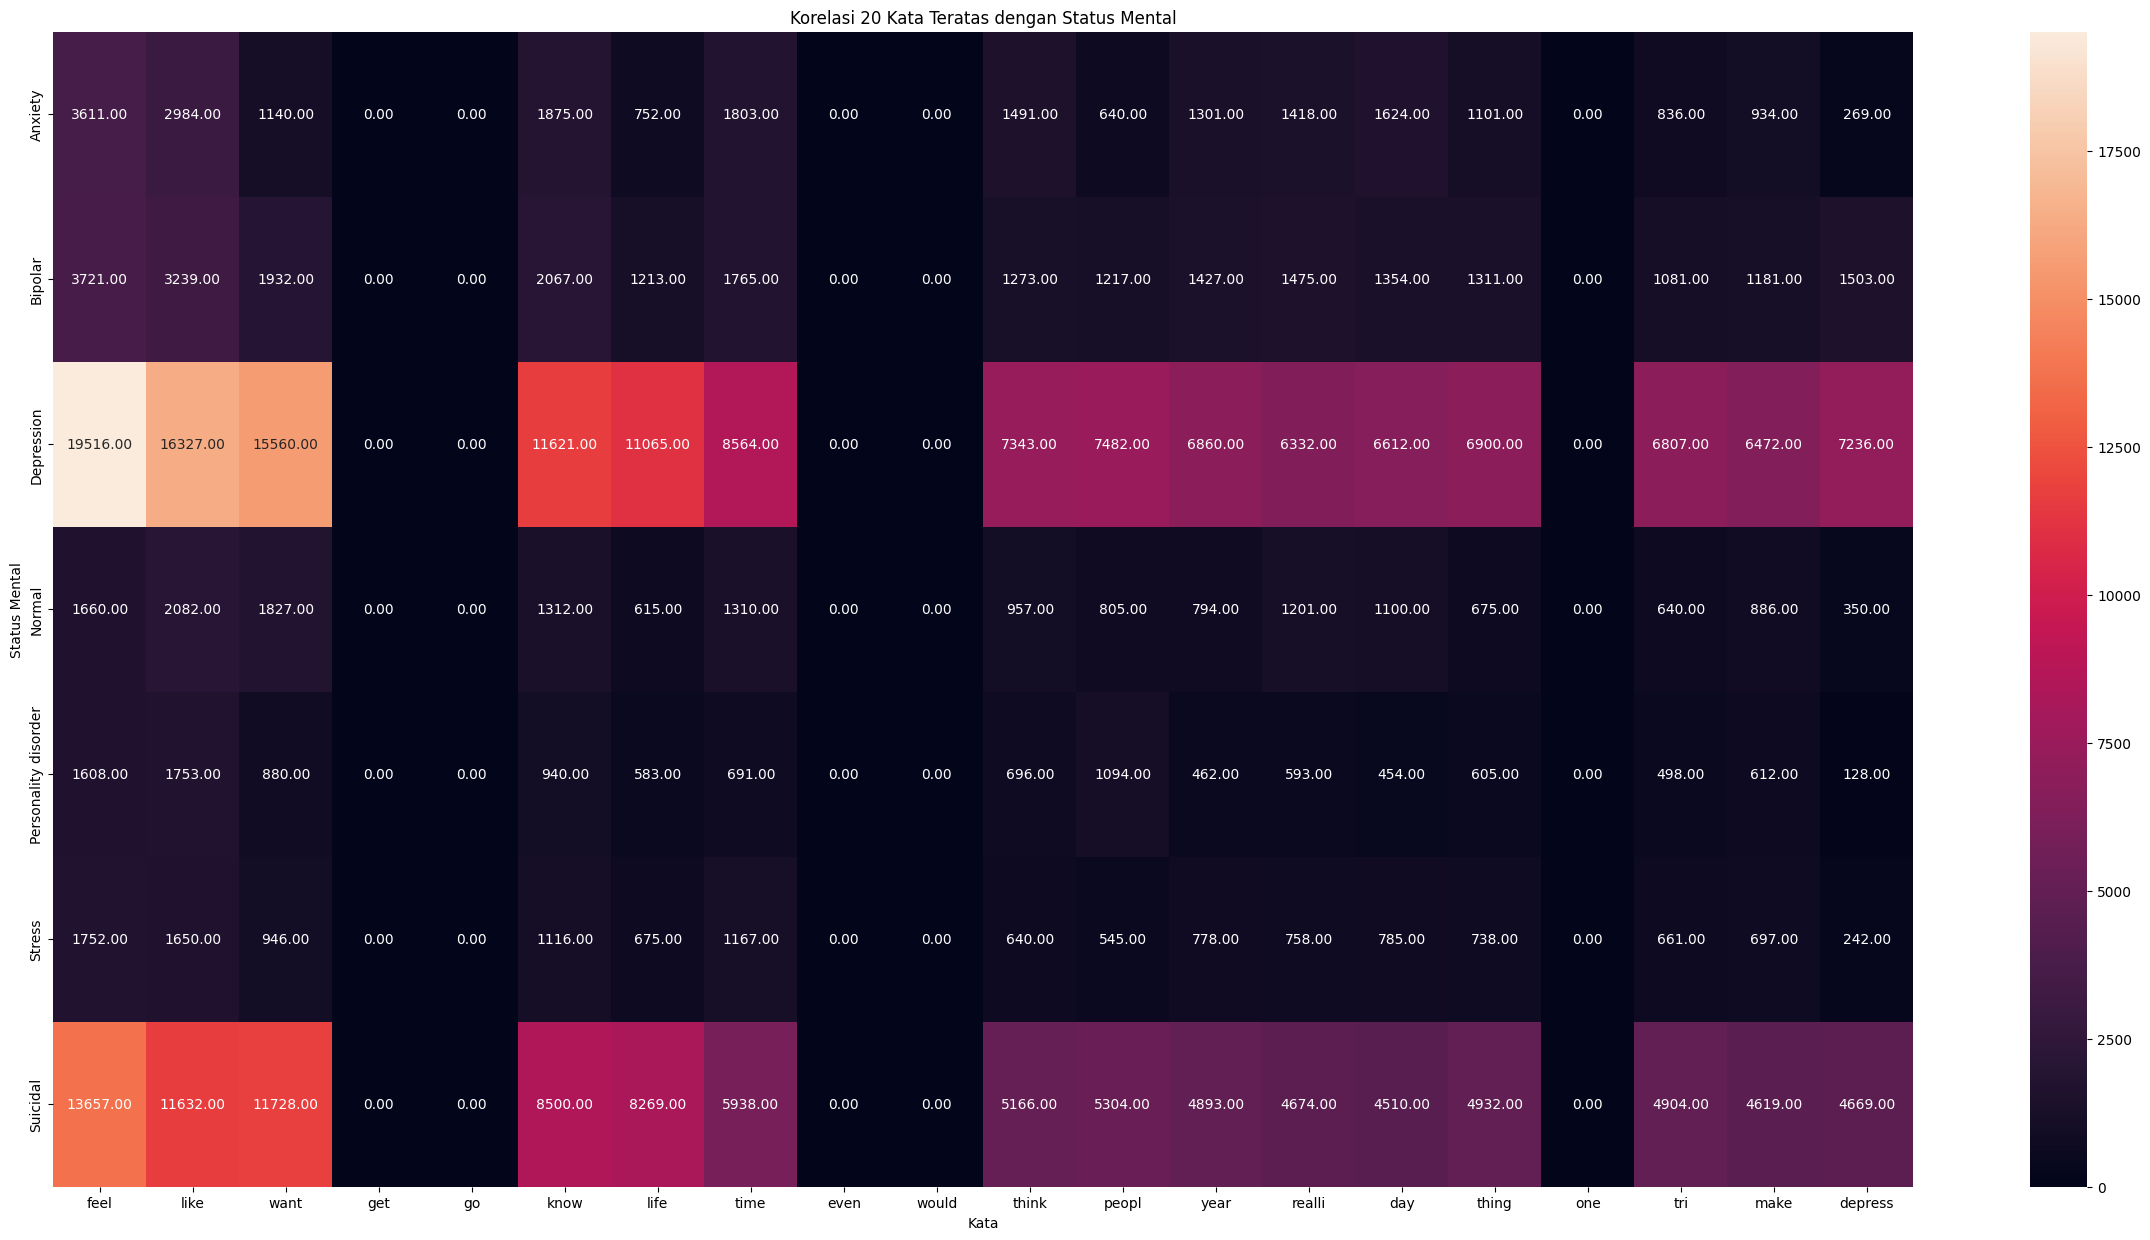

In [49]:
top_20_words = [word for word, count in most_common]
vectorizer = CountVectorizer(vocabulary=top_20_words, stop_words='english')
X = vectorizer.fit_transform(data['Processed_Tweet'])
word_count_df = pd.DataFrame(X.toarray(), columns=top_20_words)
word_count_df['status'] = data['status']
status_word_counts = word_count_df.groupby('status').sum()

plt.figure(figsize=(30, 15))
sns.heatmap(status_word_counts, annot=True, fmt='.2f')
plt.title('Korelasi 20 Kata Teratas dengan Status Mental')
plt.xlabel('Kata')
plt.ylabel('Status Mental')
plt.show()

Machine Learning Model
- Naive Bayes
- Logistic Regression
- Random Forest
- Support Vector Machine 
- XGBoost

In [50]:
rf_svm_data = data[['Processed_Tweet', 'status']]

In [51]:
x1_train, x1_test, y1_train, y1_test = train_test_split(
    rf_svm_data['Processed_Tweet'], rf_svm_data['status'], test_size=0.2,
    stratify=rf_svm_data['status'], random_state=42
)
tfidf1 = TfidfVectorizer(max_features=1000)
x1_train_tfidf = tfidf1.fit_transform(x1_train)
x1_test_tfidf = tfidf1.transform(x1_test)

In [52]:
lbl_enc = LabelEncoder()
y1_train_encoded = lbl_enc.fit_transform(y1_train)
y1_test_encoded = lbl_enc.transform(y1_test)

In [53]:
ros = RandomOverSampler(random_state=101)
X1_train_tfidf_array = x1_train_tfidf.toarray()
X1_train_ros, y1_train_ros = ros.fit_resample(X1_train_tfidf_array, y1_train_encoded)

In [54]:
X = data[['Processed_Tweet', 'num_of_characters', 'num_of_sentences']] 
y = data['status']
y = lbl_enc.fit_transform(y.values)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
x_train_tfidf = tfidf.fit_transform(X_train['Processed_Tweet'])
x_test_tfidf = tfidf.transform(X_test['Processed_Tweet'])

x_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
x_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

x_train_combined = hstack([x_train_tfidf, x_train_num])
x_test_combined = hstack([x_test_tfidf, x_test_num])

print('Number of feature words: ', len(tfidf.get_feature_names_out()))

Number of feature words:  50000


In [56]:
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(x_train_combined, y_train)

In [57]:
X_train_resampled.shape

(90664, 50002)

In [58]:
nb_model = BernoulliNB(alpha=0.1, binarize=0.0)
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101)
random_forest = RandomForestClassifier()
svm_linear = LinearSVC()
xgb_model = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='hist')

In [59]:
# 1. Naive Bayes
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_nb = nb_model.predict(x_test_combined)

In [60]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy: ", nb_accuracy)

Naive Bayes Accuracy:  0.620732053343422


In [61]:
# 2. Logistic Regression
logreg.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg.predict(x_test_combined)

In [62]:
# 3. XGBoost
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(x_test_combined)

In [63]:
# 4. Random Forest
random_forest.fit(X1_train_ros, y1_train_ros)
y_pred_rf = random_forest.predict(x1_test_tfidf.toarray())

In [64]:
# 5. Linear SVC (SVM)
svm_linear.fit(X1_train_ros, y1_train_ros)
y_pred_svm_linear = svm_linear.predict(x1_test_tfidf.toarray())

In [65]:
ml_model_reports = {
    "Naive Bayes": classification_report(y_test, y_pred_nb, target_names=lbl_enc.classes_, output_dict=True),
    "Logistic Regression": classification_report(y_test, y_pred_logreg,target_names=lbl_enc.classes_, output_dict=True),
    "Random Forest": classification_report(y1_test_encoded, y_pred_rf, target_names=lbl_enc.classes_, output_dict=True),
    "Linear SVM": classification_report(y1_test_encoded, y_pred_svm_linear, target_names=lbl_enc.classes_, output_dict=True),
    "XGBoost": classification_report(y_test, y_pred_xgb, target_names=lbl_enc.classes_, output_dict=True)
}

In [66]:
print("Classification Reports:\n")

for model_name, report in ml_model_reports.items():
    print(f"{model_name}:\n")
    df = pd.DataFrame(report).transpose()
    print(df.round(2))
    print("\n")

Classification Reports:

Naive Bayes:

                      precision  recall  f1-score   support
Anxiety                    0.67    0.57      0.62    756.00
Bipolar                    0.74    0.50      0.60    588.00
Depression                 0.61    0.49      0.55   3068.00
Normal                     0.65    0.93      0.77   3226.00
Personality disorder       0.80    0.27      0.41    235.00
Stress                     0.42    0.34      0.38    523.00
Suicidal                   0.55    0.49      0.52   2177.00
accuracy                   0.62    0.62      0.62      0.62
macro avg                  0.63    0.51      0.55  10573.00
weighted avg               0.62    0.62      0.60  10573.00


Logistic Regression:

                      precision  recall  f1-score   support
Anxiety                    0.75    0.79      0.77    756.00
Bipolar                    0.78    0.76      0.77    588.00
Depression                 0.67    0.65      0.66   3068.00
Normal                     0.87    0.

In [67]:
print("Classification Reports in Table:\n")

statuses = lbl_enc.classes_

accuracy_data = {model: report['accuracy'] for model, report in ml_model_reports.items()}
df_accuracy = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])

f1_data = {model: [report[status]['f1-score'] for status in statuses] for model, report in ml_model_reports.items()}
df_f1 = pd.DataFrame(f1_data)
df_f1.index = statuses
df_f1 = df_f1.round(3)

precision_data = {model: [report[status]['precision'] for status in statuses] for model, report in ml_model_reports.items()}
df_precision = pd.DataFrame(precision_data)
df_precision.index = statuses
df_precision = df_precision.round(3)

recall_data = {model: [report[status]['recall'] for status in statuses] for model, report in ml_model_reports.items()}
df_recall = pd.DataFrame(recall_data)
df_recall.index = statuses
df_recall = df_recall.round(3)


print("Table 1 - Accuracy Comparison")
print(df_accuracy, '\n')

print("Table 2 - F1 Score Comparison")
print(df_f1, '\n')

print("Table 3 - Precision Comparison")
print(df_precision, '\n')

print("Table 4 - Recall Comparison")
print(df_recall, '\n')


Classification Reports in Table:

Table 1 - Accuracy Comparison
                     Accuracy
Naive Bayes          0.620732
Logistic Regression  0.722406
Random Forest        0.690249
Linear SVM           0.668874
XGBoost              0.776695 

Table 2 - F1 Score Comparison
                      Naive Bayes  Logistic Regression  Random Forest  \
Anxiety                     0.617                0.773          0.751   
Bipolar                     0.596                0.767          0.724   
Depression                  0.546                0.662          0.662   
Normal                      0.770                0.882          0.825   
Personality disorder        0.406                0.619          0.342   
Stress                      0.377                0.492          0.468   
Suicidal                    0.518                0.602          0.601   

                      Linear SVM  XGBoost  
Anxiety                    0.704    0.836  
Bipolar                    0.642    0.812  
Depress

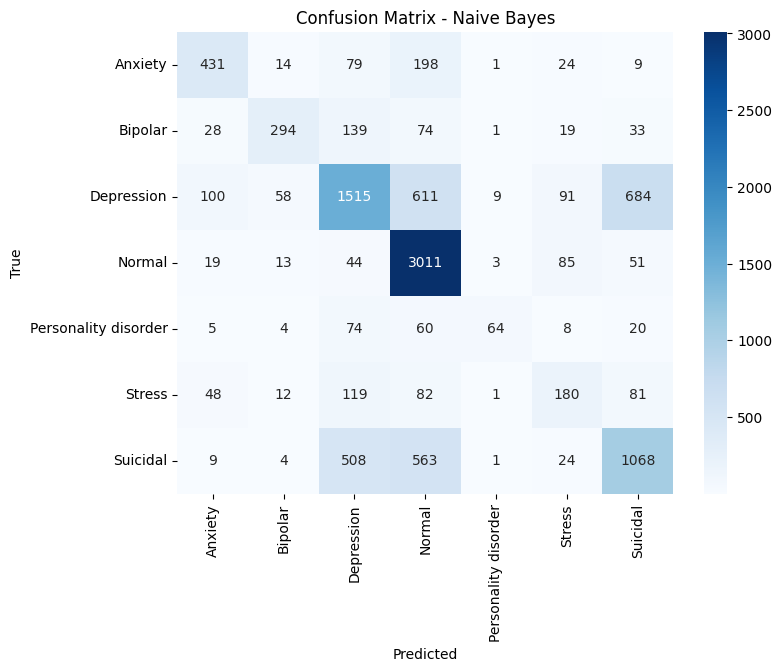

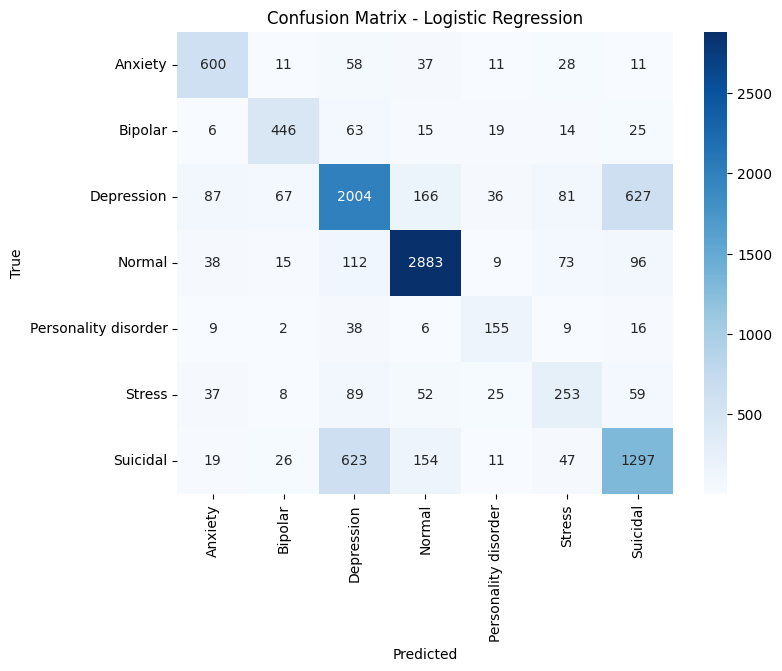

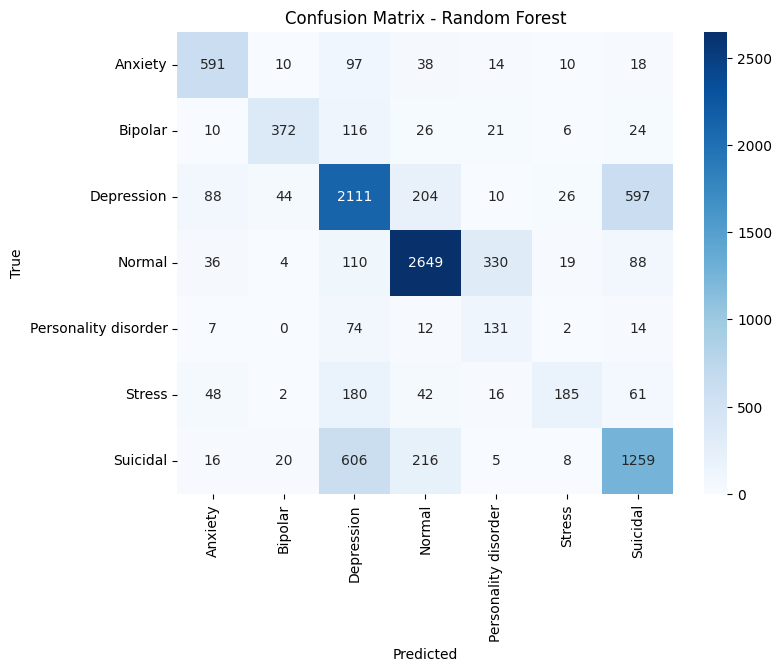

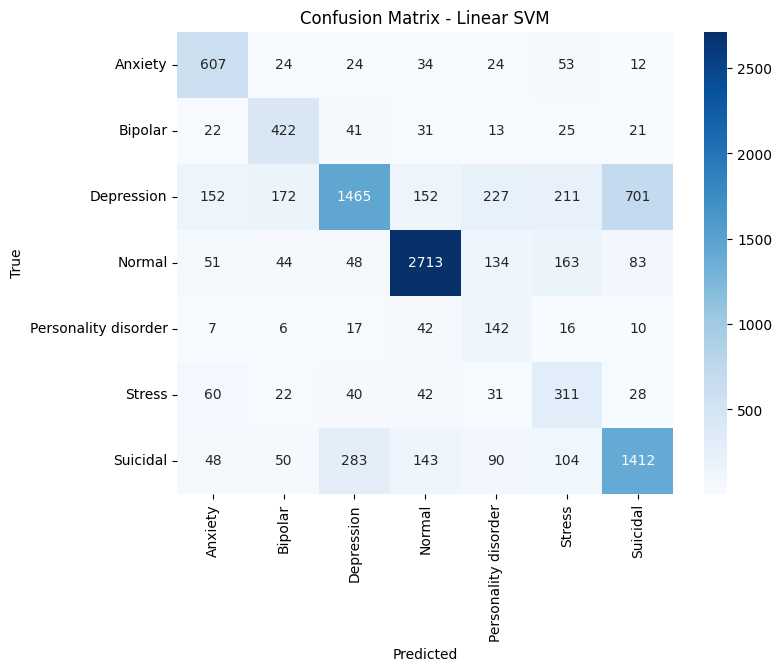

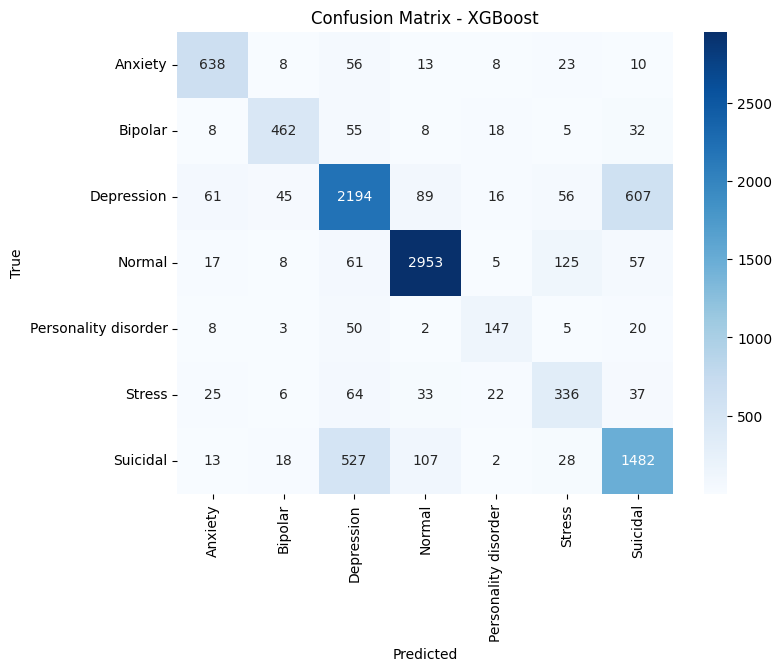

In [68]:
# confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression") 
plot_confusion_matrix(y1_test_encoded, y_pred_rf, "Random Forest")
plot_confusion_matrix(y1_test_encoded, y_pred_svm_linear, "Linear SVM")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

In [69]:
df_accuracy

,Accuracy
Naive Bayes,0.620732
Logistic Regression,0.722406
Random Forest,0.690249
Linear SVM,0.668874
XGBoost,0.776695


In [70]:
df_f1

,Naive Bayes,Logistic Regression,Random Forest,Linear SVM,XGBoost
Anxiety,0.617,0.773,0.751,0.704,0.836
Bipolar,0.596,0.767,0.724,0.642,0.812
Depression,0.546,0.662,0.662,0.586,0.722
Normal,0.770,0.882,0.825,0.849,0.918
Personality disorder,0.406,0.619,0.342,0.315,0.649
Stress,0.377,0.492,0.468,0.439,0.610
Suicidal,0.518,0.602,0.601,0.642,0.670


In [71]:
df_precision

,Naive Bayes,Logistic Regression,Random Forest,Linear SVM,XGBoost
Anxiety,0.673,0.754,0.742,0.641,0.829
Bipolar,0.737,0.776,0.823,0.570,0.840
Depression,0.611,0.671,0.641,0.764,0.730
Normal,0.655,0.870,0.831,0.859,0.921
Personality disorder,0.800,0.583,0.249,0.215,0.674
Stress,0.418,0.501,0.723,0.352,0.581
Suicidal,0.549,0.609,0.611,0.623,0.660


In [72]:
df_recall

,Naive Bayes,Logistic Regression,Random Forest,Linear SVM,XGBoost
Anxiety,0.570,0.794,0.760,0.780,0.844
Bipolar,0.500,0.759,0.647,0.734,0.786
Depression,0.494,0.653,0.685,0.476,0.715
Normal,0.933,0.894,0.819,0.838,0.915
Personality disorder,0.272,0.660,0.546,0.592,0.626
Stress,0.344,0.484,0.346,0.582,0.642
Suicidal,0.491,0.596,0.591,0.663,0.681


In [73]:
with open("naive_bayes_model.pkl", "wb") as f:
    pickle.dump(nb_model, f)
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(logreg, f)
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(random_forest, f)
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_linear, f)
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
with open("tfidf1_vectorizer_ml.pkl", "wb") as f:
    pickle.dump(tfidf1, f)
with open("tfidf_vectorizer_ml.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("label_encoder_ml.pkl", "wb") as f:
    pickle.dump(lbl_enc, f)

Machine Learning Model - Input & Prediction Testing

In [74]:
with open("xgboost_model.pkl", "rb") as f:
    xgb = pickle.load(f)

with open("naive_bayes_model.pkl", "rb") as f:
    nb_model = pickle.load(f)

with open("logistic_regression_model.pkl", "rb") as f:
    logreg = pickle.load(f)

with open("random_forest_model.pkl", "rb") as f:
    random_forest = pickle.load(f)

with open("svm_model.pkl", "rb") as f:
    svm_linear = pickle.load(f)

with open("tfidf_vectorizer_ml.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open("tfidf1_vectorizer_ml.pkl", "rb") as f:
    tfidf1 = pickle.load(f)

with open("label_encoder_ml.pkl", "rb") as f:
    label_encoder = pickle.load(f)

test_sentences = [
    "I can't sleep at night and my thoughts won't stop racing.",
    "Lately, I've been feeling so numb and disconnected from everything.",
    "Everything feels fine, just a normal day with coffee and work.",
    "I'm afraid to go outside. The world feels overwhelming.",
    "Sometimes I feel like ending it all. What's the point?",
    "I’m trying to stay strong, but my mood swings are exhausting.",
    "I'm confident, happy, and ready to face the day!",
    "My mind jumps from one idea to another. I can’t stay still.",
    "I don’t even recognize myself anymore. Who am I becoming?",
    "Feeling a bit stressed, but I think I can manage it with deep breaths.",
    "It ends tonight.I can’t do it anymore. I quit.",
    "Is it worth it?Is all the trouble, work and anxiety really worth living for.",
    "do you ever feel empty and you had to pick a number from 15 depending how you feel about it i could write my funeral speech now but what is the point in afew years i would be forgotten anyway",
    "How painful is it and what are the chances of dying from it",
    "I heard from my therapist that anger and depression often go hand in hand, but I feel like it's kinda going off the rails for me. does anyone have more experience with this?",
    "i have been struggling with health anxiety and general spiraling lately, along with a host of other mental health issues. my psychiatrist recommended i try getting back on an antidepressant as they can sometimes help with anxiety (and my healthy dose of depression needs to be managed). we are thinking of prozac since i responded well to it when i was younger..",
    "I found out that in times where my social anxiety was really bad this would also heavily influence my own self confidence and self worth. I would beat myself up for everything I did which made it even harder to overcome my social anxiety. What do you think about this?",
    "I feel like my intrusive thoughts are winning right now, and I feel bad for every thought. I feel like a terrible person and I need to remove myself from everyone because I'm a terrible person and no one would want me around. My inner voice is very mean and I just don't know anymore. I'm just so tired of it all.",
    "The girl that I fell for 10 years ago also suffers from anxiety. I haven't got the guts to let her know how I feel about her. My anxiety recently developed into agoraphobia. I've been improving but I still can't travel far. That kind of demoralized me. My question is: Can a relationship still work if both suffer from anxiety?",
    "Lately I just feel like garbage. I havent left the house much in like 2 weeks, and I've been missing class. It all feels too overwhelming for me, but being at home makes me feel like trash too...I cant win. I cant sleep right either. I wake up every other hour and im so tired...."

]

def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[\U00010000-\U0010FFFF]", "", text)
    allowed_chars = set(string.ascii_letters + "áéíóúãõàâêôç ")
    text = ''.join(c for c in text if c in allowed_chars)
    text = re.sub(r'\s+', ' ', text)
    return text

def preprocess(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer, PorterStemmer

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

for sentence in test_sentences:
    cleaned = preprocess(clean_text(sentence))

    print(f"Original: {sentence}")
    print(f"Cleaned: {cleaned}")
    sequence = tfidf.transform([cleaned])
    sequence2 = tfidf1.transform([cleaned])

    num_features = [[len(sentence), count_sentences(sentence)]]  
    num_features = hstack([sequence, num_features]) 

    tfidf_values = sequence.toarray()[0]
    tfidf_features = tfidf.get_feature_names_out()

    word_tfidf = {word: tfidf_values[i] for i, word in enumerate(tfidf_features) if tfidf_values[i] > 0}  # Only show non-zero values
    # print("TF-IDF Analysis:")
    # for word, tfidf_val in word_tfidf.items():
    #     print(f"  {word}: {tfidf_val:.4f}")

    pred_xgb = xgb.predict(num_features)
    pred_nb = nb_model.predict(num_features)
    pred_logreg = logreg.predict(num_features)
    pred_rf = random_forest.predict(sequence2.toarray())
    pred_svm = svm_linear.predict(sequence2.toarray())

    print(f"XGBoost Prediction: {label_encoder.inverse_transform(pred_xgb)}")
    print(f"Naive Bayes Prediction: {label_encoder.inverse_transform(pred_nb)}")
    print(f"Logistic Regression Prediction: {label_encoder.inverse_transform(pred_logreg)}")
    print(f"Random Forest Prediction: {label_encoder.inverse_transform(pred_rf)}")
    print(f"Linear SVM Prediction: {label_encoder.inverse_transform(pred_svm)}\n")

Original: I can't sleep at night and my thoughts won't stop racing.
Cleaned: cant sleep night thought wont stop race
XGBoost Prediction: ['Normal']
Naive Bayes Prediction: ['Normal']
Logistic Regression Prediction: ['Normal']
Random Forest Prediction: ['Normal']
Linear SVM Prediction: ['Normal']

Original: Lately, I've been feeling so numb and disconnected from everything.
Cleaned: late ive feel numb disconnect everyth
XGBoost Prediction: ['Depression']
Naive Bayes Prediction: ['Normal']
Logistic Regression Prediction: ['Depression']
Random Forest Prediction: ['Normal']
Linear SVM Prediction: ['Depression']

Original: Everything feels fine, just a normal day with coffee and work.
Cleaned: everyth feel fine normal day coffe work
XGBoost Prediction: ['Normal']
Naive Bayes Prediction: ['Normal']
Logistic Regression Prediction: ['Normal']
Random Forest Prediction: ['Normal']
Linear SVM Prediction: ['Anxiety']

Original: I'm afraid to go outside. The world feels overwhelming.
Cleaned: im af